MLND Capstone Development
=============

In [3]:
import numpy as np
import tensorflow as tf

Data exploration
-------------

First, we need to download our dataset.

In [4]:
from urllib import urlretrieve
from os.path import isfile, isdir
from os import mkdir
from tqdm import tqdm
import tests
import tarfile

data_folder_path = 'data'
pascal_2007_foldername = 'pascal_2007'
pascal_2007_folderpath = "{}/{}".format(data_folder_path, pascal_2007_foldername)
pascal_2007_files = {'VOCtrainval_06-Nov-2007.tar': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
                     'VOCtest_06-Nov-2007.tar': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
                     'VOCdevkit_08-Jun-2007.tar': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar'}

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

# Create data director if it doesn't exist
if not isdir(data_folder_path):
    mkdir(data_folder_path)
    
# Create pascal_2007 data directory if it doesn't exist
if not isdir(pascal_2007_folderpath):
    mkdir(pascal_2007_folderpath)
        
# Download & extract data files
for filename, url in pascal_2007_files.iteritems():
    filepath = "./{}/{}".format(pascal_2007_folderpath, filename)
    
    if not isfile(filepath):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=filename) as pbar:
            urlretrieve(url, filepath, pbar.hook)

    # Extract data achrive files
    # Todo: Consider checking for already existing extractions, so we don't
    # have to re-extract the files.
    print "Extracting {}".format(filename)
    with tarfile.open(filepath) as tar:
        tar.extractall("{}/".format(pascal_2007_folderpath))
        tar.close()

print 'Testing...'
tests.test_pascal_2007_downloads()
tests.test_pascal_2007_extracts()

Extracting VOCdevkit_08-Jun-2007.tar
Extracting VOCtest_06-Nov-2007.tar
Extracting VOCtrainval_06-Nov-2007.tar
Testing...
PASCAL VOC 2007 data files downloaded.
PASCAL VOC 2007 data files extracted.


Now that we have the dataset downloaded and extracted. Let's take a look at some images and the corresponding annotations to get a better feel for what's in the dataset.

Inspecting image #000032...
Type: <type 'numpy.ndarray'>
Shape & type: (281, 500, 3) uint8
4 objects


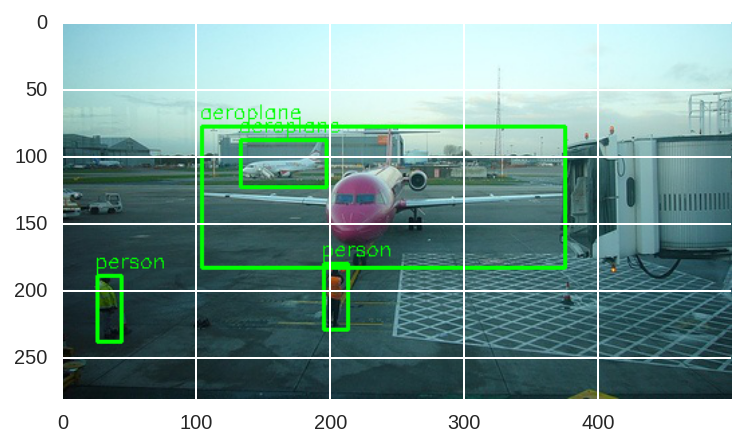

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
from scipy.ndimage import imread

def load_image(image_id):
    example_image_path = '{}/VOCdevkit/VOC2007/JPEGImages/{}.jpg'.format(pascal_2007_folderpath, image_id)
    return imread(example_image_path)

def parse_annotations_for_image(image_id):
    example_image_annotations_path = '{}/VOCdevkit/VOC2007/Annotations/{}.xml'.format(pascal_2007_folderpath, image_id)
    tree = ET.parse(example_image_annotations_path)
    root = tree.getroot()
    
    image = {'width': int(root.find('size').find('width').text),
             'height': int(root.find('size').find('height').text),
             'depth': int(root.find('size').find('depth').text)}
    
    objects = []
    
    for obj in root.findall('object'):    
        object_class = obj.find('name').text
        difficult = obj.find('difficult').text == '1'
        pose = obj.find('pose').text
        truncated = obj.find('truncated').text == '1'
    
        xmin = int(obj.find('bndbox').find('xmin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        
        objects.append({'class': object_class, 
                        'difficult': difficult,
                        'pose': pose,
                        'truncated': truncated,
                        'xmin': xmin,
                        'xmax': xmax,
                        'ymin': ymin,
                        'ymax': ymax})
    
    return image, objects

def draw_bounding_boxes_on_image(image, objects):
    bounding_box_color = (0, 255, 0)
    
    for obj in objects:
        cv2.rectangle(image, (obj['xmin'], obj['ymin']), (obj['xmax'], obj['ymax']), bounding_box_color, 2)
        cv2.putText(image, obj['class'], (obj['xmin'] - 2, obj['ymin'] - 6), 0, 0.5, bounding_box_color)

def inspect_image(image_id):
    image = load_image(image_id)
    _, objects = parse_annotations_for_image(image_id)
    draw_bounding_boxes_on_image(image, objects)
    
    print 'Inspecting image #{}...'.format(image_id)
    print 'Type: {}'.format(type(image))
    print 'Shape & type: {} {}'.format(image.shape, image.dtype)
    print len(objects), 'objects'
    
    plt.imshow(image)
    
inspect_image('000032')

Now we have the ability to insepct an image with ground truth bounding boxes and object classifications overlaid. Next, we should inspect the overall dataset.

In [52]:
import pandas as pd

main_imageset_path = '{}/VOCdevkit/VOC2007/ImageSets/Main'.format(pascal_2007_folderpath)

pascal_voc_2007_detection_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
                                     'bottle', 'bus', 'car', 'cat', 'chair',
                                     'cow', 'diningtable', 'dog', 'horse',
                                     'motorbike', 'person', 'pottedplant',
                                     'sheep', 'sofa', 'train', 'tvmonitor']


def load_imageset(split):
    imageset = {}
    
    imageset['split'] = split
    imageset['image_ids'] = _load_imageset_image_ids(split)
    imageset['images'] = pd.DataFrame(columns=['image_id', 'width', 'height', 'depth'])
    imageset['objects'] = pd.DataFrame(columns=['image_id', 'class', 'pose', 'truncated', 'difficult', 
                                                'xmin', 'ymin', 'xmax', 'ymax'])
    _load_image_data(imageset)
    
    return imageset


def _load_imageset_image_ids(split):
    image_ids = []
    
    if split in ['train', 'val', 'trainval', 'test']:
        with open('{}/{}.txt'.format(main_imageset_path, split)) as f:
            image_ids = f.readlines()
    
        image_ids = [x.strip() for x in image_ids] 

    return image_ids


def _load_image_data(imageset):
    for image_id in imageset['image_ids']:
        image, objects = parse_annotations_for_image(image_id)
        
        imageset['images'] = imageset['images'].append({'image_id': image_id, 
                                   'width': image['width'],
                                   'height': image['height'],
                                   'depth': image['depth']
                                  }, ignore_index=True)
        
        for obj in objects:            
            imageset['objects'] = imageset['objects'].append({'image_id': image_id, 
                                        'class': obj['class'], 
                                        'pose': obj['pose'], 
                                        'truncated': obj['truncated'], 
                                        'difficult': obj['difficult'],         
                                        'xmin': obj['xmin'], 
                                        'ymin': obj['ymin'], 
                                        'xmax': obj['xmax'], 
                                        'ymax': obj['ymax']}, ignore_index=True)
    

def analyze_imageset(imageset):
    imageset['count'] = len(imageset['image_ids'])
        
    print len(imageset['images']), 'images'
    print len(imageset['objects']), 'objects'


print 'Loading train imageset...'
train_imageset = load_imageset('train')
analyze_imageset(train_imageset)

print ''
print 'Loading val imageset...'
val_imageset = load_imageset('val')
analyze_imageset(val_imageset)

Analyzing train imageset...
2501 images
7844 objects

Analyzing val imageset...
2510 images
7818 objects


In [71]:
print train_imageset['images'].head()
print train_imageset['objects'].head()

  image_id  width  height  depth object_count
0   000012  500.0   333.0    3.0          NaN
1   000017  480.0   364.0    3.0          NaN
2   000023  334.0   500.0    3.0          NaN
3   000026  500.0   333.0    3.0          NaN
4   000032  500.0   281.0    3.0          NaN
  image_id    class         pose truncated difficult   xmin   ymin   xmax  \
0   000012      car         Rear     False     False  156.0   97.0  351.0   
1   000017   person         Left     False     False  185.0   62.0  279.0   
2   000017    horse         Left     False     False   90.0   78.0  403.0   
3   000023  bicycle  Unspecified      True     False    9.0  230.0  245.0   
4   000023  bicycle      Frontal      True     False  230.0  220.0  334.0   

    ymax  
0  270.0  
1  199.0  
2  336.0  
3  500.0  
4  500.0  


In [74]:
print 'Max train width: ', train_imageset['images']['width'].max()
print 'Min train width: ', train_imageset['images']['width'].min()

print 'Max train height: ', train_imageset['images']['height'].max()
print 'Min train height: ', train_imageset['images']['height'].min()

print 'Max train depth: ', train_imageset['images']['depth'].max()
print 'Min train depth: ', train_imageset['images']['depth'].min()

print ''

print 'Max val width: ', val_imageset['images']['width'].max()
print 'Min val width: ', val_imageset['images']['width'].min()

print 'Max val height: ', val_imageset['images']['height'].max()
print 'Min val height: ', val_imageset['images']['height'].min()

print 'Max val depth: ', val_imageset['images']['depth'].max()
print 'Min val depth: ', val_imageset['images']['depth'].min()

Max train width:  500.0
Min train width:  127.0
Max train height:  500.0
Min train height:  96.0
Max train depth:  3.0
Min train depth:  3.0

Max val width:  500.0
Min val width:  174.0
Max val height:  500.0
Min val height:  99.0
Max val depth:  3.0
Min val depth:  3.0


In [84]:
def difficult_percentage(df):
    return len(df[df.difficult]) / float(len(df)) * 100

print '{0:.2f}% difficult objects in train dataset'.format(difficult_percentage(train_imageset['objects']))
print '{0:.2f}% difficult objects in validation dataset'.format(difficult_percentage(val_imageset['objects']))

19.67% difficult objects in train dataset
19.33% difficult objects in validation dataset


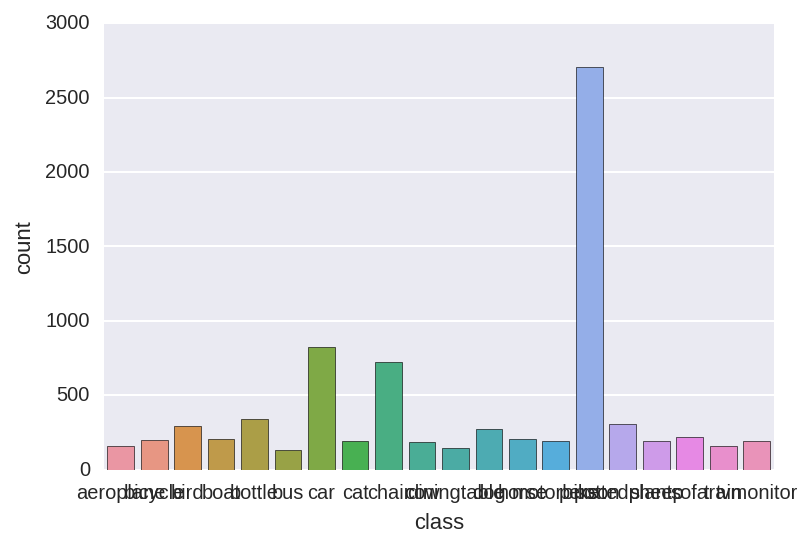

In [70]:
import seaborn as sns

a = sns.countplot(x='class', data=train_imageset['objects'].sort_values(by='class'))

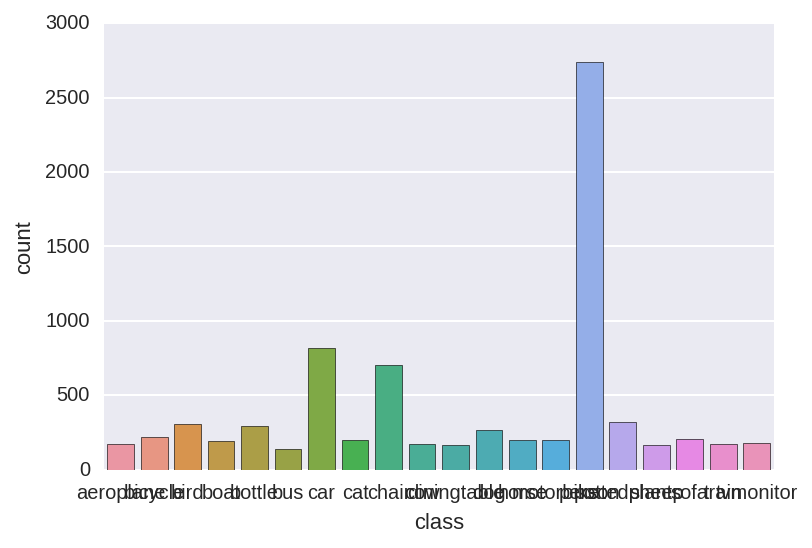

In [65]:
b = sns.countplot(x='class', data=val_imageset['objects'].sort_values(by='class'))

The PASCAL VOC 2007 dataset is already pre-split between train and validation sets, so we'll first see if we can use this. After the analysis, we can see that the split is about 50/50 in terms of number of images and objects. 

As we can see from the cursory analysis, all of the images are different sizes, but all are constrainted to be within a 500x500 square, presumably maintaining aspect ratio. Additionally, all images have a depth of 3, so we don't have to worry about correcting for any outliers in that regard.

Next, I looked at the percentage of objects that were identified as "difficult". Luckily, they are roughly equal, so we don't have to worry that one cut of the data is easier to detect objects than the other.

Finally, we inspected the class distribution within the set and compared the train and validation sets in this regard. It's not balanceda—there are significantly more person objects than anything else—but there is an even distribution between the training and validation sets, so while we should pay attention if our network is significantly better at detecting people, I think we can use this default splitting strategy for the project.

Preprocessing
=============